## Introduction

The used car sales service 'Rusty Bargain' is developing an application to attract new customers. In this application, the user should be able to quickly find out the market value of his car.

There is a historical database with:
- technical specifications;
- trim versions;
- and prices.

It will be necessary to build a machine learning model to determine the value of a vehicle.

'Rusty Bargain' is interested in:
- the quality of the prediction;
- the speed of the prediction;
- the time required for training.

## Data Preparation

### Importing Data

In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import MaxAbsScaler
import xgboost as xgb
import lightgbm as lgb
from lightgbm import LGBMRegressor
from lightgbm import early_stopping, log_evaluation
import time

import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing

In [2]:
# Importing Data from file.
df = pd.read_csv('car_data.csv')

### Pre-Data Analysis

In [3]:
# Data preview
display(df.head())
print()
df.info()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object

In [4]:
# Missing values
print(df.isna().sum())

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Mileage                  0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64


The description of the column titles is observed using capital letters and the words are not divided. They will only be suitable for lowercase letters and the words will be divided by underscore (_).

Missing values ​​were also observed in 5 columns and these will be investigated to make a decision on whether or not to fill in this information.

The columns `DateCrawled`, `DateCreated` and `LastSeen` have data of the 'object' type. These will not be adjusted, as they will be excluded as they do not influence the proposed study.

### Data Preparation

In [5]:
# Changing column names
df.columns = ['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox', 'power', 'model', 'mileage', 'registration_month', 'fuel_type', 'brand', 'not_repaired', 'date_created', 'number_of_pictures', 'postal_code', 'last_seen']

# Verification
display(df.head(1))

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16


In [6]:
# Excluding 'date_crawled', 'date_created' and 'last_seen' columns
df.drop(['date_crawled', 'date_created', 'last_seen'], axis=1, inplace=True)

# Checking
display(df.head(1))

,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,number_of_pictures,postal_code
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,0,70435


Investigating unique values ​​in columns

In [7]:
# Analysis of the 'vehicle_type' column
print(df['vehicle_type'].sort_values().unique())

['bus' 'convertible' 'coupe' 'other' 'sedan' 'small' 'suv' 'wagon' nan]


In [8]:
# Analysis of the 'gearbox' column
print(df['gearbox'].sort_values().unique())

['auto' 'manual' nan]


In [9]:
# Analysis of the 'power' column
print(df['power'].sort_values().unique())
print()
print(df['power'].value_counts())

[    0     1     2     3     4     5     6     7     8     9    10    11
    12    13    14    15    16    17    18    19    20    21    22    23
    24    25    26    27    28    29    30    31    32    33    34    35
    36    37    38    39    40    41    42    43    44    45    46    47
    48    49    50    51    52    53    54    55    56    57    58    59
    60    61    62    63    64    65    66    67    68    69    70    71
    72    73    74    75    76    77    78    79    80    81    82    83
    84    85    86    87    88    89    90    91    92    93    94    95
    96    97    98    99   100   101   102   103   104   105   106   107
   108   109   110   111   112   113   114   115   116   117   118   119
   120   121   122   123   124   125   126   127   128   129   130   131
   132   133   134   135   136   137   138   139   140   141   142   143
   144   145   146   147   148   149   150   151   152   153   154   155
   156   157   158   159   160   161   162   163   

There are vehicles that were launched with very low powers, such as 0 (zero), 1 (one), 2 (two), as well as very high powers such as 20000 (twenty thousand), 19312 (nineteen thousand three hundred and one dose).

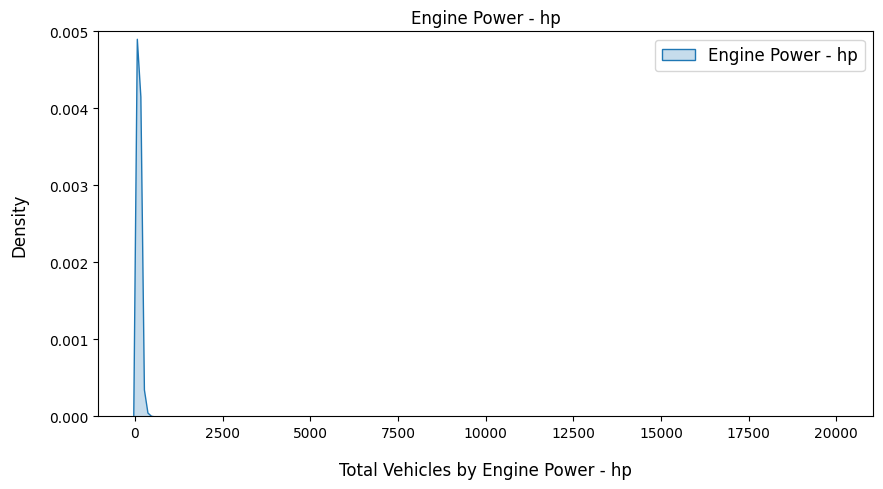

In [10]:
# Plotting density graph
plt.figure(figsize=(10, 5))
sns.kdeplot(df['power'], label='Engine Power - hp', fill=True)
plt.legend(fontsize=12)
plt.title('Engine Power - hp')
plt.xlabel('Total Vehicles by Engine Power - hp', fontsize=12, labelpad = 15)
plt.ylabel('Density', fontsize=12, labelpad=15)
plt.ylim(0, 0.005)    
plt.show()

The values ​​of 60hp and 600hp will be considered as outlier cut lines. Lines with values ​​outside this range will be excluded from the base.

In [11]:
# Excluding outliers
df = df.query("(power > 60) and (power < 600)")

# Checking
print(df['power'].sort_values().unique())

[ 61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78
  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96
  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114
 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132
 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150
 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168
 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186
 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204
 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222
 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240
 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258
 259 260 261 262 264 265 266 267 268 269 270 271 272 273 274 275 276 277
 278 279 280 281 282 283 284 285 286 287 288 289 290 292 293 294 295 296
 297 298 299 300 301 303 304 305 306 307 308 309 31

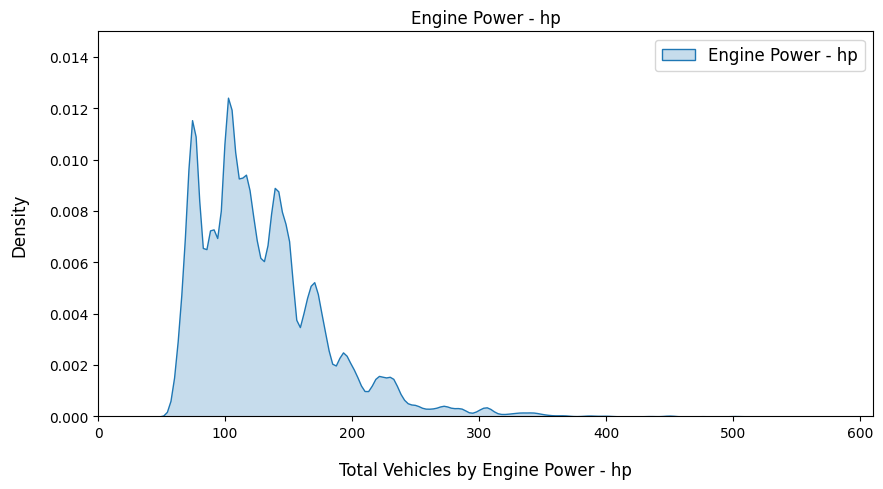

In [12]:
# Replotting the density graph
plt.figure(figsize=(10, 5))
sns.kdeplot(df['power'], label='Engine Power - hp', fill=True)
plt.legend(fontsize=12)
plt.title('Engine Power - hp')
plt.xlabel('Total Vehicles by Engine Power - hp', fontsize=12, labelpad = 15)
plt.ylabel('Density', fontsize=12, labelpad=15)
plt.ylim(0, 0.015)
plt.xlim(0, 610)
plt.show()

Even though we may still have values ​​considered outliers above 400hp, it is completely plausible to have vehicles with these powers.

In [13]:
# Analysis of the 'model' column
print(df['model'].sort_values().unique())

['100' '145' '147' '156' '159' '1_reihe' '1er' '200' '2_reihe' '300c'
 '3_reihe' '3er' '4_reihe' '500' '5_reihe' '5er' '6_reihe' '6er' '7er'
 '80' '850' '90' '900' '9000' '911' 'a1' 'a2' 'a3' 'a4' 'a5' 'a6' 'a8'
 'a_klasse' 'accord' 'agila' 'alhambra' 'almera' 'altea' 'amarok' 'antara'
 'arosa' 'astra' 'auris' 'avensis' 'aveo' 'aygo' 'b_klasse' 'b_max'
 'beetle' 'berlingo' 'bora' 'boxster' 'bravo' 'c1' 'c2' 'c3' 'c4' 'c5'
 'c_klasse' 'c_max' 'c_reihe' 'caddy' 'calibra' 'captiva' 'carisma'
 'carnival' 'cayenne' 'cc' 'ceed' 'charade' 'cherokee' 'citigo' 'civic'
 'cl' 'clio' 'clk' 'clubman' 'colt' 'combo' 'cooper' 'cordoba' 'corolla'
 'corsa' 'cr_reihe' 'croma' 'crossfire' 'cuore' 'cx_reihe' 'defender'
 'delta' 'discovery' 'doblo' 'ducato' 'duster' 'e_klasse' 'eos' 'escort'
 'espace' 'exeo' 'fabia' 'fiesta' 'focus' 'forester' 'forfour' 'fortwo'
 'fox' 'freelander' 'fusion' 'g_klasse' 'galant' 'galaxy' 'getz' 'gl'
 'glk' 'golf' 'grand' 'i3' 'i_reihe' 'ibiza' 'impreza' 'insignia' 'jazz'
 'j

In [14]:
# Analysis of the 'registration_month' column
print(df['registration_month'].sort_values().unique())
print()
print(df['registration_month'].value_counts())
print()
print('Percentage of values ​​entered as zero in the month of registration:', \
      df['registration_month'].value_counts()[0] / len(df) * 100)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12]

registration_month
3     27777
6     25684
4     23850
5     23656
7     22074
10    21059
12    19600
11    19565
9     19316
1     18415
8     18272
0     17811
2     17216
Name: count, dtype: int64

Percentage of values ​​entered as zero in the month of registration: 6.493373922237007


An inconsistency is observed that 17811 occurrences with month '0' (zero). This is equivalent to 6.49% of the rows and will be deleted.

In [15]:
# Deleting rows with '0' in the month of registration
df = df.query("(registration_month > 0)")

# Checking
print(df['registration_month'].sort_values().unique())
print()
print(df['registration_month'].value_counts())

[ 1  2  3  4  5  6  7  8  9 10 11 12]

registration_month
3     27777
6     25684
4     23850
5     23656
7     22074
10    21059
12    19600
11    19565
9     19316
1     18415
8     18272
2     17216
Name: count, dtype: int64


In [16]:
# Analysis of the 'fuel_type' column
print(df['fuel_type'].sort_values().unique())
print()
print(df['fuel_type'].value_counts())

['cng' 'electric' 'gasoline' 'hybrid' 'lpg' 'other' 'petrol' nan]

fuel_type
petrol      152828
gasoline     85862
lpg           4463
cng            450
hybrid         203
other           47
electric        27
Name: count, dtype: int64


The fuel types 'petrol' and 'gasoline' are the same thing and so they will all be standardized as `petrol`.

In [17]:
# Setting fuel type 'gasoline' to 'petrol'
df['fuel_type'] = df['fuel_type'].replace('gasoline', 'petrol')

# Checking
print(df['fuel_type'].value_counts())

fuel_type
petrol      238690
lpg           4463
cng            450
hybrid         203
other           47
electric        27
Name: count, dtype: int64


In [18]:
# Analysis of the 'brand' column
print(df['brand'].sort_values().unique())

['alfa_romeo' 'audi' 'bmw' 'chevrolet' 'chrysler' 'citroen' 'dacia'
 'daewoo' 'daihatsu' 'fiat' 'ford' 'honda' 'hyundai' 'jaguar' 'jeep' 'kia'
 'lada' 'lancia' 'land_rover' 'mazda' 'mercedes_benz' 'mini' 'mitsubishi'
 'nissan' 'opel' 'peugeot' 'porsche' 'renault' 'rover' 'saab' 'seat'
 'skoda' 'smart' 'sonstige_autos' 'subaru' 'suzuki' 'toyota' 'volkswagen'
 'volvo']


In [19]:
# Analysis of the 'not_repaired' column
print(df['not_repaired'].sort_values().unique())

['no' 'yes' nan]


In [20]:
display(df.head(1))
# Analysis of column 'number_of_pictures'
print(df['number_of_pictures'].sort_values().unique())

,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,number_of_pictures,postal_code
1,18300,coupe,2011,manual,190,NaN,125000,5,petrol,audi,yes,0,66954


[0]


The number of photos identified in the lines is not observed and therefore this column will be excluded, as it does not impact the predictions.

In [21]:
# Deleting column 'number_of_pictures'
df.drop(['number_of_pictures'], axis=1, inplace=True)

# Checking
display(df.head(1))

,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,postal_code
1,18300,coupe,2011,manual,190,NaN,125000,5,petrol,audi,yes,66954


In [22]:
# Resetting the index
df = df.reset_index(drop=True)

After these data preparations, the missing values ​​still present will be analyzed.

### Reanalysis of data after preparation

In [23]:
# Data preview
display(df.head())
print()
df.info()

,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,postal_code
0,18300,coupe,2011,manual,190,NaN,125000,5,petrol,audi,yes,66954
1,9800,suv,2004,auto,163,grand,125000,8,petrol,jeep,NaN,90480
2,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,91074
3,3600,small,2008,manual,69,fabia,90000,7,petrol,skoda,no,60437
4,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,33775



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256484 entries, 0 to 256483
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               256484 non-null  int64 
 1   vehicle_type        242623 non-null  object
 2   registration_year   256484 non-null  int64 
 3   gearbox             253199 non-null  object
 4   power               256484 non-null  int64 
 5   model               247701 non-null  object
 6   mileage             256484 non-null  int64 
 7   registration_month  256484 non-null  int64 
 8   fuel_type           243880 non-null  object
 9   brand               256484 non-null  object
 10  not_repaired        224557 non-null  object
 11  postal_code         256484 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 23.5+ MB


In [24]:
# Missing values
print(df.isna().sum())

price                     0
vehicle_type          13861
registration_year         0
gearbox                3285
power                     0
model                  8783
mileage                   0
registration_month        0
fuel_type             12604
brand                     0
not_repaired          31927
postal_code               0
dtype: int64


In [25]:
# Percentages of missing values ​​by columns
print('Percentage of missing Vehicle Type values:', df.vehicle_type.isna().sum() / len(df) * 100)
print('Percentage of missing values for Transmission Case Type:', df.gearbox.isna().sum() / len(df) * 100)
print('Percentage of missing values for Vehicle Model:', df.model.isna().sum() / len(df) * 100)
print('Percentage of missing Fuel Type values:', df.fuel_type.isna().sum() / len(df) * 100)
print('Percentage of missing values if vehicle was Repaired:', df.not_repaired.isna().sum() / len(df) * 100)
print()

# Percentages of rows with missing values
print('Percentage of rows with missing values:', df.isna().any(axis=1).sum() / len(df) * 100)

Percentage of missing Vehicle Type values: 5.404235741800658
Percentage of missing values for Transmission Case Type: 1.2807816471982658
Percentage of missing values for Vehicle Model: 3.4243851468317708
Percentage of missing Fuel Type values: 4.91414669141155
Percentage of missing values if vehicle was Repaired: 12.447949969588747

Percentage of rows with missing values: 19.90494533772087


There are still 19.9% ​​of rows with missing values ​​and they will be deleted so as not to impact model training.

In [26]:
# Deleting rows with missing values
df = df.dropna()
df = df.reset_index(drop=True)

# Checking
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205431 entries, 0 to 205430
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               205431 non-null  int64 
 1   vehicle_type        205431 non-null  object
 2   registration_year   205431 non-null  int64 
 3   gearbox             205431 non-null  object
 4   power               205431 non-null  int64 
 5   model               205431 non-null  object
 6   mileage             205431 non-null  int64 
 7   registration_month  205431 non-null  int64 
 8   fuel_type           205431 non-null  object
 9   brand               205431 non-null  object
 10  not_repaired        205431 non-null  object
 11  postal_code         205431 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 18.8+ MB


## Model training

### Preparing data

The data will be prepared for model testing and for this the categorical features will be encoded to numerical labels.

In [27]:
# Creating a copy of the Dataframe
df_new = df.copy()

# Selecting columns with categorical characteristics
object_columns = df_new.select_dtypes(include='object')

# Encoding categorical columns
encoder = OrdinalEncoder()
codification = pd.DataFrame(encoder.fit_transform(object_columns), columns=object_columns.columns)

# Replacing the original df columns with the encoded columns
df_new[object_columns.columns] = codification

# Verificando
display(df_new.head())
print()
df_new.info()

,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,postal_code
0,1500,5.0,2001,1.0,75,114.0,150000,6,5.0,36.0,0.0,91074
1,3600,5.0,2008,1.0,69,99.0,90000,7,5.0,31.0,0.0,60437
2,650,4.0,1995,1.0,102,11.0,150000,10,5.0,2.0,1.0,33775
3,2200,1.0,2004,1.0,109,8.0,150000,8,5.0,25.0,0.0,67112
4,2000,4.0,2004,1.0,105,10.0,150000,12,5.0,19.0,0.0,96224



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205431 entries, 0 to 205430
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   price               205431 non-null  int64  
 1   vehicle_type        205431 non-null  float64
 2   registration_year   205431 non-null  int64  
 3   gearbox             205431 non-null  float64
 4   power               205431 non-null  int64  
 5   model               205431 non-null  float64
 6   mileage             205431 non-null  int64  
 7   registration_month  205431 non-null  int64  
 8   fuel_type           205431 non-null  float64
 9   brand               205431 non-null  float64
 10  not_repaired        205431 non-null  float64
 11  postal_code         205431 non-null  int64  
dtypes: float64(6), int64(6)
memory usage: 18.8 MB


### Dividing Data into Features and Purpose

The DataFrame 'df_new' is the one that will be used for modeling, as it was prepared from the original 'df'.

The data will be separated into feature sets and objectives.

In [28]:
# Preparing feature and target sets
features = df_new.drop(['price'], axis=1)
target = df_new['price']

print(features.shape)
print(target.shape)

(205431, 11)
(205431,)


### Separating the data sets

The data will be split as follows, starting from `df_new`:
- 20% for testing
- 80% for training

And this training data will be split as follows:
- 20% for validation
- 80% for training

In [29]:
# Splitting training and testing sets
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.20, random_state=12345)

print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)

(164344, 11)
(164344,)
(41087, 11)
(41087,)


In [30]:
# Splitting the training set into training and validation
features_train, features_valid, target_train, target_valid = train_test_split(
    features_train, target_train, test_size=0.20, random_state=12345)

print(features_train.shape)
print(target_train.shape)
print(features_valid.shape)
print(target_valid.shape)

(131475, 11)
(131475,)
(32869, 11)
(32869,)


## Training Regression Models

### Decision Tree

In [31]:
# Decision Tree Modeling searching for the best hyperparameter.
best_model_ad = None
best_result = 10000
best_depth = 0
best_time = 0
for depth in range(1, 15):
    model_ad = DecisionTreeRegressor(random_state=12345, max_depth=depth)
    model_ad.fit(features_train, target_train) 
    predictions_valid_ad = model_ad.predict(features_valid)
    result = mse(target_valid, predictions_valid_ad) ** 0.5
    if result < best_result:
        best_model_ad = model_ad
        best_result = result
        best_depth = depth
        

print(f"The best REQM result of the Decision Tree is with the max_depth hyperparameter of {best_depth}: {best_result}")

The best REQM result of the Decision Tree is with the max_depth hyperparameter of 13: 2004.8680690054737


In [32]:
%%timeit
# Decision Tree model prediction time
best_model_ad.predict(features)

72.4 ms ± 20 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Random Forest

In [33]:
# Modelagem da Floresta Aleatória buscando o melhor hiperparâmetro.
best_model = None
best_result = 10000
best_est = 0
best_depth = 0
for est in range(40, 51, 5):
    for depth in range (10, 15, 5):
        model_fa = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth)
        model_fa.fit(features_train, target_train)
        predictions_valid_fa = model_fa.predict(features_valid) 
        result = mse(target_valid, predictions_valid_fa) ** 0.5
        if result < best_result:
            best_model = model_fa
            best_result = result
            best_est = est
            best_depth = depth

print("The best RMSE result for Random Forest is:", best_result, ", with the hyperparameter n_estimators of:", best_est, "and better depth of:", depth)

The best RMSE result for Random Forest is: 1952.2887702031803 , with the hyperparameter n_estimators of: 45 and better depth of: 10


In [34]:
%%timeit
# Random Forest model runtime
best_model.predict(features)

918 ms ± 39.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Linear Regression

In [35]:
# Linear Regression Modeling
model_rl = LinearRegression() 
model_rl.fit(features_train, target_train) 
predictions_valid_rl = model_rl.predict(features_valid) 

result = mse(target_valid, predictions_valid_rl) ** 0.5 
print("Linear Regression RMSE value is:", result)

Linear Regression RMSE value is: 2967.8264317873654


In [36]:
%%timeit
# Linear Regression Runtime
model_rl.predict(features)

13.2 ms ± 790 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Conclusions

The model with the best **REQM** score was the Random Forest model, while the one with the worst performance was the Linear Regression model.

In terms of execution time, the Random Forest model had the worst performance to train, while the Linear Regression model was the fastest.

## Boosting

### XGBoost

In [37]:
# XGBoost Modeling
lbl = LabelEncoder()
features_train.vehicle_type = lbl.fit_transform(features_train.vehicle_type.astype(str))
features_train.gearbox = lbl.fit_transform(features_train.gearbox.astype(str))
features_train.model = lbl.fit_transform(features_train.model.astype(str))
features_train.fuel_type = lbl.fit_transform(features_train.fuel_type.astype(str))
features_train.brand = lbl.fit_transform(features_train.brand.astype(str))
features_train.not_repaired = lbl.fit_transform(features_train.not_repaired.astype(str))

features_valid.vehicle_type = lbl.fit_transform(features_valid.vehicle_type.astype(str))
features_valid.gearbox = lbl.fit_transform(features_valid.gearbox.astype(str))
features_valid.model = lbl.fit_transform(features_valid.model.astype(str))
features_valid.fuel_type = lbl.fit_transform(features_valid.fuel_type.astype(str))
features_valid.brand = lbl.fit_transform(features_valid.brand.astype(str))
features_valid.not_repaired = lbl.fit_transform(features_valid.not_repaired.astype(str))


# Creating XGBoost model
model_xgb = xgb.XGBRegressor(random_state=12345, eval_metric='rmse')
model_xgb.fit(features_train, target_train)
predictions_xgb = model_xgb.predict(features_valid)
result = mse(target_valid, predictions_xgb) ** 0.5
print()
print("The REQM value of the XGBoost Model is:", result)


The REQM value of the XGBoost Model is: 1805.0235455527998


In [38]:
%%timeit
# XGBoost Model Runtime
model_xgb.predict(features)

330 ms ± 55.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Light GBM

In [39]:
# Light GBM Modeling
# Preparing data
features_train['vehicle_type'] = pd.Categorical(features_train['vehicle_type'])
features_train['gearbox'] = pd.Categorical(features_train['gearbox'])
features_train['model'] = pd.Categorical(features_train['model'])
features_train['fuel_type'] = pd.Categorical(features_train['fuel_type'])
features_train['brand'] = pd.Categorical(features_train['brand'])
features_train['not_repaired'] = pd.Categorical(features_train['not_repaired'])

features_valid['vehicle_type'] = pd.Categorical(features_valid['vehicle_type'])
features_valid['gearbox'] = pd.Categorical(features_valid['gearbox'])
features_valid['model'] = pd.Categorical(features_valid['model'])
features_valid['fuel_type'] = pd.Categorical(features_valid['fuel_type'])
features_valid['brand'] = pd.Categorical(features_valid['brand'])
features_valid['not_repaired'] = pd.Categorical(features_valid['not_repaired'])


# Creating LightGBM dataset
lgb_train = lgb.Dataset(features_train, label=target_train, params={'verbose': -1}, free_raw_data=False)
lgb_valid = lgb.Dataset(features_valid, label=target_valid, reference=lgb_train, params={'verbose': -1}, free_raw_data=False)

# Defining parameters for the LightGBM model
params = {
    'objective': 'regression',
    'metric': 'root_mean_squared_error',
    'boosting_type': 'gbdt',
    'num_leaves': 10,
    'learning_rate':0.05,
    'feature_fraction':0.5,
    'random_state': 12345,
    'verbose':-1
}


# Training LightGBM Model
model_lgb = lgb.train(params, lgb_train, valid_sets=[lgb_valid], num_boost_round=100, callbacks=[early_stopping(stopping_rounds=10), log_evaluation(0)])

# Validation set predictions
predictions_valid_lgb = model_lgb.predict(features_valid)

result = mse(target_valid, predictions_valid_lgb) ** 0.5 
print()
print("The REQM value of the LightGB Model is:", result)

Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's rmse: 2485.5

The REQM value of the LightGB Model is: 2485.49991431267


In [40]:
# Preparing data
features_lgb = features.copy()

features_lgb['vehicle_type'] = pd.Categorical(features_lgb['vehicle_type'])
features_lgb['gearbox'] = pd.Categorical(features_lgb['gearbox'])
features_lgb['model'] = pd.Categorical(features_lgb['model'])
features_lgb['fuel_type'] = pd.Categorical(features_lgb['fuel_type'])
features_lgb['brand'] = pd.Categorical(features_lgb['brand'])
features_lgb['not_repaired'] = pd.Categorical(features_lgb['not_repaired'])

features_lgb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205431 entries, 0 to 205430
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   vehicle_type        205431 non-null  category
 1   registration_year   205431 non-null  int64   
 2   gearbox             205431 non-null  category
 3   power               205431 non-null  int64   
 4   model               205431 non-null  category
 5   mileage             205431 non-null  int64   
 6   registration_month  205431 non-null  int64   
 7   fuel_type           205431 non-null  category
 8   brand               205431 non-null  category
 9   not_repaired        205431 non-null  category
 10  postal_code         205431 non-null  int64   
dtypes: category(6), int64(5)
memory usage: 9.2 MB


In [41]:
%%timeit
# Light GBM Model Runtime
model_lgb.predict(features_lgb[:2])

9.74 ms ± 393 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Conclusion

Boosting models have a good balance between speed and prediction quality of the model. Among all the models, Regression and Boosting, the one with the best RMSE result and also the fastest prediction is the XG Boost Model. It is suggested that Rusty Bargain implement this machine learning model to predict the market value of a car.